---
title: 'Logistic Regression'
author: 'Andre Xiao'
date: '2024-04-09'
image: 'logistic.png'
description: 'Implementing and experimenting with logistic regression.'
format: html
code-annotations: hover
number-sections: true
---

![Image source: https://images.spiceworks.com/wp-content/uploads/2022/04/11040522/46-4.png](https://images.spiceworks.com/wp-content/uploads/2022/04/11040522/46-4.png)

Referenced Code: [logistic.py](https://github.com/andrexiao85/andrexiao85.github.io/blob/main/posts/logistic_post/logistic.py)

## Abstract

Logistic regression aims to minimize the empirical risk for a given data set by adjusting the weight vector $\mathbf{w}$ using gradient descent and momentum. In this study, I implement and experiment with logistic regression for binary classification. The first experiment uses logistic regression with vanilla gradient descent ($\beta = 0$) and analyzes the loss over iterations and the final decision boundary. The second experiment applies logistic regression with momentum ($\beta > 0$) and compares its loss over iterations and final decision boundary with its vanilla counterpart. The last experiment analyzes overfitting when the number of features exceeds the number of data points in the data set. For each experiment, I will first generate classification data then run a training loop. For the first two experiments, I visualize the loss over iterations and the final decision boundaries, while for the last experiment, I compare the accuracy of the model for the training data to the testing data.

Through these experiments, I found that logistic regression with vanilla gradient descent does converge to a correct weight vector $\mathbf{w}$, while logistic regression with momentum converges faster to the correct weight vector $\mathbf{w}$ and finds a better decision boundary given the same number of iterations as vanilla logistic regression. Furthermore, when the number of features exceeds the number of data points, the model can achieve 100% training accuracy, but will do worse on testing data due to overfitting.

## Implementing Logistic Regression

Logistic regression performs classification by minimizing the empirical risk
$$L(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^n [-y_i\log(\sigma(s_i))-(1-y_i)\log(1-\sigma(s_i))]$$
where $s_i = \langle w, x_i\rangle$ and $\sigma(s_i) = \frac{1}{1+e^{-s_i}}$.

To do this, at each iteration $k$, logistic regression performs the following update:
$$\mathbf{w}_{k+1} = \mathbf{w}_k - \alpha\nabla L(\mathbf{w}_k) + \beta(\mathbf{w}_k - \mathbf{w}_{k-1})$$
where
$$\nabla L(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^n (\sigma(s_i)-y_i)\mathbf{x}_i$$
is the gradient of the empirical risk, $\alpha$ and $\beta$ are learning rates, and $\mathbf{w}_k - \mathbf{w}_{k-1}$ is the momentum term.

In my implementation of logistic regression, `loss()` computes $L(\mathbf{w})$, `grad()` computes $\nabla L(\mathbf{w})$, and `step()` computes $w_{k+1}$ as seen below and in perceptron.py. 

```python
def loss(self, X, y):
    sigma = 1/(1+torch.exp(-self.score(X)))
    return (-y*torch.log(sigma) - (1-y)*torch.log(1-sigma)).mean()

def grad(self, X, y):
    sigma = 1/(1+torch.exp(-self.score(X)))
    return ((sigma - y)[:, None]*X).mean()

def step(self, X, y, alpha = 0.01, beta = 0):
    old_w = torch.clone(self.model.w)
    self.model.w += -alpha*self.model.grad(X, y) + beta*(self.model.w - self.model.w_)
    self.model.w_ = old_w
```

## Experiments

In this section, I will be running the following three experiments using my logistic regression algorithm:

1. **Vanilla gradient descent:** When $p_{dim} = 2$, when $\alpha$ is sufficiently small and $\beta = 0$, gradient descent for logistic regression converges to a weight vector $\mathbf{w}$ that looks visually correct. Furthermore, the loss should decrease monotonically. To demonstrate this, I will visualize the loss over iterations and the final decision boundary.

2. **Benefits of momentum:** On the same data, gradient descent with momentum (e.g. $\beta = 0.9$) can converge to the correct $\mathbf{w}$ in fewer iterations than vanilla gradient descent (with $\beta = 0$). To demonstrate this, I will visualize the loss over iterations and the final decision boundaries for both.

3. **Overfitting:** I will generate two sets of data where `p_dim > n_points`. The first set of data will be the training data and the second set will be the test data. I will train a logistic regression model on the first set of data with 100% accuracy, then analyze the accuracy on the test data.

Before, I run these experiments, I will create functions to generate and plot my data, train the data, and visualize the results.

In [2]:
#| code-fold: true
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer

In [3]:
import torch
import matplotlib.pyplot as plt

def classification_data(n_points = 300, noise = 0.2, p_dims = 2): # <1>
    
    y = torch.arange(n_points) >= int(n_points/2) # <1>
    y = 1.0*y # <1>
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims)) # <1>
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1) # <1>
    
    return X, y # <1>

def plot_classification_data(X, y, ax): # <2>
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2." # <2>
    targets = [0, 1] # <2>
    markers = ["o" , ","] # <2>
    for i in range(2): # <2>
        ix = y == targets[i] # <2>
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i]) # <2>
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$") # <2>

def draw_line(w, x_min, x_max, ax, **kwargs): # <3>
    w_ = w.flatten() # <3>
    x = torch.linspace(x_min, x_max, 101) # <3>
    y = -(w_[0]*x + w_[2])/w_[1] # <3>
    l = ax.plot(x, y, **kwargs) # <3>

def train(model, X, y, alpha = 0.01, beta = 0, iters = 100):
    opt = GradientDescentOptimizer(model) # <4>

    torch.manual_seed(1) # <5>
    model.loss(X, y) # <5>

    loss_vec = [] # <6>

    for _ in range(iters):

        loss = model.loss(X, y) # <7>
        loss_vec.append(loss)

        opt.step(X, y, alpha = alpha, beta = beta) # <8>

    return loss_vec

1. Creates data for classification.
2. Plots data.
3. Draws decision boundary.
4. Initializes logistic regression.
5. Set seed for reproducible results.
6. Initialize for tracking.
7. Tracks progress.
8. Updates weight vector $\mathbf{w}$.


### Vanilla Gradient Descent

Let's take a look at vanilla gradient descent when $\beta = 0$. First, let's generate and plot the data.

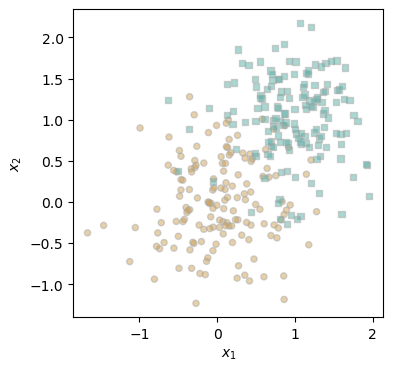

In [4]:
#| code-fold: true
#| fig-cap: 300 data points with `noise = 0.5` in 2 dimensions.
#| label: fig-data

torch.manual_seed(1)
X, y = classification_data(noise = 0.5)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_classification_data(X, y, ax)

Below are the loss over iterations and the final decision boundary for this data set.

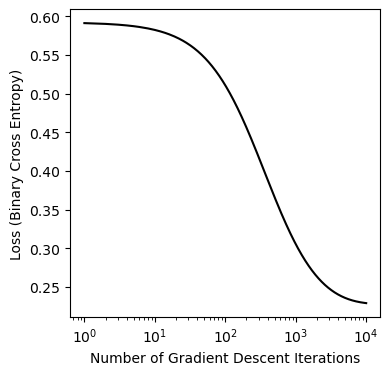

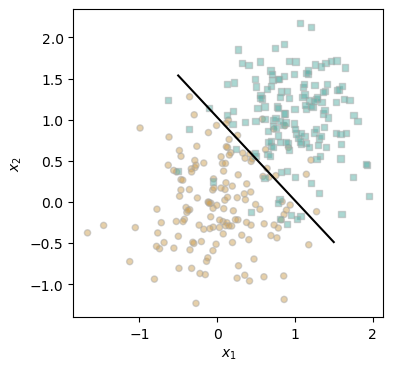

In [5]:
#| code-fold: true
#| fig-cap: Vanilla gradient descent converges to a weight vector $\mathbf{w}$.
#| fig-subcap:
#|  - Loss over iterations.
#|  - Decision boundaries.
#| label: fig-vanilla
#| layout-ncol: 2

LR1 = LogisticRegression()
loss_vec1 = train(LR1, X, y, alpha = 0.02, beta = 0, iters = 10000)

plt.figure(figsize = (4, 4))
plt.plot(torch.arange(1, len(loss_vec1)+1), loss_vec1, color = "black")
plt.semilogx()
plt.gca().set(xlabel = "Number of Gradient Descent Iterations", ylabel = "Loss (Binary Cross Entropy)")

fig2, ax2 = plt.subplots(1, 1, figsize = (4, 4)) 
plot_classification_data(X, y, ax2)
draw_line(LR1.w, -0.5, 1.5, ax2, color = "black")

As we can see in @fig-vanilla, the vanilla gradient descent converges to some $\mathbf{w}$ that looks correct. More iterations will result in a more correct $\mathbf{w}$.

### Benefits of Momentum

Now, we'll take a look at the benefits of momentum. Gradient descent with momentum (e.g. $\beta = 0.9$) should converge to the correct weight vector in fewer iterations than vanilla gradient descent ($\beta = 0$). For this experiment, let's use $\beta = 0.9$. The loss over iterations and decision boundaries for both are displayed below.

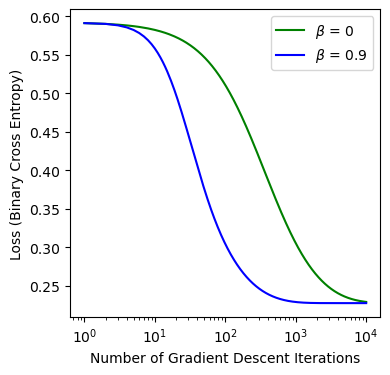

In [6]:
#| code-fold: true
#| fig-cap: Gradient descent with momentum converges faster to the correct weight vector $\mathbf{w}$ than its vanilla counterpart.
#| label: fig-momentum

LR2 = LogisticRegression()
loss_vec2 = train(LR2, X, y, alpha = 0.02, beta = 0.9, iters = 10000)
plt.figure(figsize = (4, 4))
plt.plot(torch.arange(1, len(loss_vec1)+1), loss_vec1, color = 'green', label = r'$\beta$ = 0')
plt.semilogx()
plt.gca().set(xlabel = "Number of Gradient Descent Iterations", ylabel = "Loss (Binary Cross Entropy)")

plt.plot(torch.arange(1, len(loss_vec2)+1), loss_vec2, color = 'blue', label = r'$\beta$ = 0.9')
plt.semilogx()
plt.gca().set(xlabel = "Number of Gradient Descent Iterations", ylabel = "Loss (Binary Cross Entropy)")
plt.legend();

# fig, ax = plt.subplots(1, 1, figsize = (4, 4)) 
# plot_classification_data(X, y, ax)
# draw_line(LR1.w, -0.5, 1.5, ax, color = 'green', linestyle = 'dashed')
# draw_line(LR2.w, -0.5, 1.5, ax, color = 'blue')
# plt.gca().get_lines()[0].set_label(r"$\beta$ = 0")
# plt.gca().get_lines()[1].set_label(r"$\beta$ = 0.9")
# plt.legend(loc = 'lower right');

From @fig-momentum, we can see that gradient descent with momentum converges to the correct weight vector $\mathbf{w}$ faster than its vanilla counterpart.

### Overfitting

In this section, we'll explore overfitting for the logistic regression model. I'll first create training and test data where `n_points > p_dims`.

In [7]:
X_train, y_train = classification_data(n_points = 50, noise = 0.5, p_dims = 100)
X_test, y_test = classification_data(n_points = 50, noise = 0.5, p_dims = 100)

Next, I'll train the model over the training data `X_train` and `y_train`.

In [8]:
LR3 = LogisticRegression()
loss_vec3 = train(LR3, X_train, y_train, alpha = 0.01, beta = 0.9, iters = 1000)
(1.0*(LR3.predict(X_train) == y_train)).mean()

tensor(1.)

We can see that we have achieved an accuracy of 100%. Let's see what the accuracy is when predicting the test data `X_test` and `y_test`.

In [9]:
(1.0*(LR3.predict(X_test) == y_test)).mean()

tensor(0.8400)

The accuracy was much lower for the test data (about 14%). This is most likely due to overfitting. Given the number of features (`p_dims = 100`), the model is not able to generalize well to new data due to insufficient data points in the training set. Let's look at the confusion matrix.

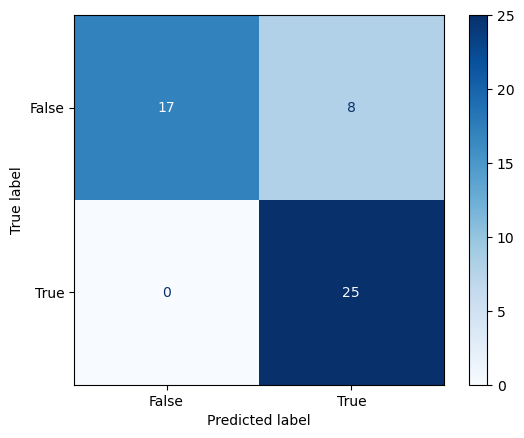

In [10]:
#| code-fold: true
#| fig-cap: Confusion matrix for testing data.
#| label: fig-cm

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, LR3.predict(X_test))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot(cmap = 'Blues')
plt.show()

From @fig-cm, we can see that the model correctly predicted all the positives, but it also produced eight false positives.

## Discussion


From these experiments, I found that logistic regression with momentum converges faster to a correct weight vector $\mathbf{w}$ than its vanilla counterpart and produces a more accurate decision boundary in the same number of iterations. Additionally, when the number of features `p_dims` exceeds the number of data points `n_points`, logistic regression is prone to overfitting. It was able to obtain a training accuracy of 100%, but only produced a testing accuracy of 86%. This is most likely due to the lack of data points given the number of features. As a result, the model didn't have enough information during training to generalize well to unseen data.